# **PyCoTools Tutorial** 

This tutorial provides information on how to simulate a COPASI model, set up, run and analyse parameter estimations and calculate profile likelihoods using COPASI. Generally the architechture follows COPASI as much as possible with nomenclature and any optional arguments provided by COPASI are accessible via PyCoTools via use of keyword arguments. Each keyword argument has a default value that can be over-ridden by manually passing the keyword argument to a class. The Kholodenko2000 model is used as a show case model in this tutorial. PyCoTools interfaces with COPASI by modifying components of XML in the same way that COPASI does. This means that a model can simply be opened at any point during an analysis to varify things are working correctly

# **Installation**


From a command line or terminal with administrative privalleges, use:
        > pip install PyCoTools
        
The source code is also available on [GitHub](https://github.com/CiaranWelsh/PyCoTools)

## Setting up a Workspace

Since the input to most of the classes in the `pycopi` module are strings containing the path to a copasi file and a user  often requires custom output filenames (rather than the defaults), its common to have a numerous file paths to manage at any one time. One way to deal with this is:
            1. Conduct your analysis from a new folder containing the .cps file of interest. 
            2. Create a blank `__init__.py' file in this folder
            3. Create a module called (for instance) `FilePaths.py` 
            4) Place a class inside `FilePaths` containing paths relevant to your analysis. 

Here is an example: 

In [1]:
#FilePaths.py
class KholodenkoExample():
    def __init__(self):
        ## path to folder containing kholodenko example
        if sys.platform=='win32':
            self.current_directory='D:\MPhil\Python\My_Python_Modules\Modelling_Tools\PyCoTools\PyCoTools\Examples\KholodenkoExample'
        else:
            self.current_directory=r'/sharedlustre/users/b3053674/2017/Jan/Kholod/KholodenkoExample'
        ## Kholodenko filename
        self.copasi_filename=r'Kholodenko.cps'
        ## full path to kholodenko model
        self.kholodenko_model=os.path.join(self.current_directory,self.copasi_filename)
        ## full path to the time course output
        self.timecourse_report=os.path.join(self.current_directory,'KholodenkoTimeCourseOutput.txt')
        ## full path to the noisy time course output
        self.noisy_timecourse_report=os.path.join(self.current_directory,'NoisyKholodenkoTimeCourseOutput.txt')
        ## Full path to parameter estimation results file
        self.PEData_file=os.path.join(self.current_directory,'PEResultsFile.txt')
        ## Full path to a folder containing all data from initial multiple global parameter estimations
        self.PEData_dir=os.path.join(self.current_directory,'PEResults')
        ## Full path to file containing secondary local parameter estimation (starting with best values from self.PEData_dir)
        self.local_PEData_dir=os.path.join(self.current_directory,'LocalPEDataResults')
        ## Pre-run parameter estimation data pickle file
        self.PEData_pickle=os.path.join(self.current_directory,'KholodenkoExamplePEData.pickle')

These paths are now available  for the rest of the `.py` files in the current directory by instantiating an instance of `KholodenkoExample()` and 'dotting' into them. 

# Run a Time Course 

The `pycopi.TimeCourse` class enables a user to run an COPASI model deterministically. Future versions of PyCoTools will implement the alternative sovlers that COPASI offers which will be accessible via a keyword argument, but presently this feature is not implemented. 

From the directory containing FilePaths.py:

In [2]:
import PyCoTools
from FilePaths import KholodenkoExample
## allow plotting in this document
%matplotlib inline

## instantiate instance of KholodenoExample to manage directories 
K=KholodenkoExample()

To run deterministic time course with kholodenko model we have a few options. We can:
    1. Collect all copasi output as tab separated file specified as argument to the `ReportName` keyword.

In [ ]:
PyCoTools.pycopi.TimeCourse(K.kholodenko_model,
                        ReportName=K.timecourse_report,
                        ## Intervals*StepSize must equal End
                        End=1000,    
                        Intervals=50,
                        StepSize=20)

    2. Plot and save results in the same directory as the model file

In [ ]:
PyCoTools.pycopi.TimeCourse(K.kholodenko_model,
                            ReportName=K.timecourse_report,
                            End=1000,
                            Intervals=50,
                            StepSize=20,
                            Plot='true',
                            SaveFig='true')

    3. Collect results only for selected model variables only by passing a list to the `Metabolites` keyword:

In [ ]:
PyCoTools.pycopi.TimeCourse(K.kholodenko_model,
                            ReportName=K.timecourse_report,
                            End=1000,
                            Intervals=50,
                            StepSize=20,
                            Plot='true',
                            SaveFig='true',
                            Metabolites=['Mek1-P','Mek1'])

    4. Play around with graph graphics. Note that these arguments are simply passed on to matplotlib and therefore more documenation can be found [here](http://matplotlib.org/)

In [ ]:
PyCoTools.pycopi.TimeCourse(K.kholodenko_model,
                            ReportName=K.timecourse_report,
                            End=1000,
                            Intervals=50,
                            StepSize=20,
                            Plot='true',
                            SaveFig='true',
                            Metabolites=['Mek1-P','Mek1'],
                            LineWidth=8,
                            MarkerSize=15,
                            MarkerColor='g',
                            AxisSize=20,
                            FontSize=25,
                            LineStyle='-',
                            XTickRotation=45,
                            
                           )

## Adding Noise

This data is now going to be used in the next section for parameter estimation. To make things more interesting the following function can be used to add some noise the the data. Note that this method of adding noise is bias toward larger valued profiles but in the present context that doesn't really matter. 

In [ ]:
import pandas,numpy, FilePaths, os

def add_noise(f, noise_factor=0.05):
    '''
    Add noise to time course data
    
    f:
        Single experiment file to add noise too
    
    noise_factor:
        limits the amount of noise to add. Must be float between 0 and 1
        . default is 0.05 for 5% 
        
    ==========
    Returns: pandas.DataFrame containing noisy data 
    
    '''
    ## check file is real file
    assert os.path.isfile(f),'{} is not a file'.format(f)
    ## read into pandas
    df=pandas.read_csv(f,sep='\t')
    ## Count number of data points to add noise too
    ## remember to account for the time varible by minus 1 from column dimension 
    number_of_data_points= df.shape[0]*(df.shape[1]-1)
    ## sample from uniform distribution 'number_of_data_points' times and assign to u vector
    u= numpy.random.uniform(1-noise_factor,1+noise_factor,number_of_data_points)
    ## reshape u vector into a 'u matrix'
    u_matrix= u.reshape(df.shape[0],df.shape[1]-1)
    ## remove the time colum but save as 't' variable for later
    try:
        
        t=df['Time']
        df.drop('Time',axis=1,inplace=True)
        df_noise=pandas.DataFrame(u_matrix,columns=df.columns)
    except KeyError:
        return None
    ## Check we have the corect shape for matrix
    assert df.shape==df_noise.shape
    ## Perform dot multiplication on two matrices to get noisy matrix
    noise= df_noise.rmul(df,axis=0)
    ## change index to be time
    noise.index=t
    ## return noisy vector
    return noise

if __name__=='__main__':
    ## instantiate FilePaths.KhodenkoExmaple to get necessary file paths
    K=FilePaths.KholodenkoExample()
    ## add noise to simulated kholodenko output and output to tab separated file. 
    add_noise(K.timecourse_report).to_csv(K.noisy_timecourse_report,sep='\t')


# Parameter Estimation 

The ParameterEstimation class is the only class in PyCoTools that is not fully automated as it required additional input from the user, such as which variables to estimate and between what boundaries. To use `ParameterEstimation`:
        1. Instantiate instance of `ParameterEstimation`. This is where arguments and optional keyword arguments 
            such as `Method` and the method parameters are specified. 
        2. Use the `write_item_template()` method to output a file called 'fitItemTemplate.xlsx' 
            containing model variables, start values, boundaries and some additional information
            which is used under the hood for creating fit items. 
        3. Use the `set_up()` method to set up the parameter estimation.This can be varified by 
            opening the model and looking at the parameter estimation 
        4. Optionally use the `run()` method to run the model with CopasiSE

## Instantiate Instance of ParameterEstimation

The `ParameterEstimation` class takes two positional arguments - absolute paths to 1) the model and 2) the parameter estimation data. The `ParameterEstimation` class can take lists of experiment files to set up multifit parameter estimations at the same time.

For example to:

    1. Set up a parameter estimation with a single time course experiment and all other parameters default:

In [ ]:
PE= PyCoTools.pycopi.ParameterEstimation(K.kholodenko_model,
                                         K.noisy_timecourse_report)

Now `PE.kwargs` can be used to view default parameters

In [ ]:
for i in sorted(PE.kwargs.keys()):
    print i,PE.kwargs[i]

   2. Set up a parameter estimation with two time course experiment files

In [ ]:
## quickly modify the K.noisy_time_course_report name for demonstration 
import os
second_timecourse= K.noisy_timecourse_report[:-4]+'2.txt'

## quickly run another time course for demontration 
PyCoTools.pycopi.TimeCourse(K.kholodenko_model,ReportName=second_timecourse,End=1000,Intervals=50,StepSize=20)


PE= PyCoTools.pycopi.ParameterEstimation(K.kholodenko_model,
                                           [K.noisy_timecourse_report,second_timecourse])

for i in sorted(PE.kwargs.keys()):
    print i,PE.kwargs[i]

Note that the following varibales automatically change to lists of `len(ExperimentFiles)`:
* RowOrientation
* ExperimentType
* FirstRow
* NormalizeWeightsPerExperiment
* RowContainingNames
* Separator
* WeightMethod

These options (like all others) are described in detail on the [COPASI manual](http://copasi.org/Support/User_Manual/Tasks/Parameter_Estimation/).

If any experiments are steady state experiments or if indivudal time course experiments are to be treated differently then custom lists need to be passed to these arguments. A user should consult the technical documentation distributed with PyCoTools for more details. 

Other important `kwargs` for parameter estimation are `Method` which specified which optimization algorithm to use as well as all options for all algorithms. To see which options are needed for which algorithm, simply open the `parameter estimation task` in the COPASI user interface and select the appropiate algorithm.

## Use `PE.write_item_template()`

In [ ]:
import FilePaths
K=FilePaths.KholodenkoExample()
PE= PyCoTools.pycopi.ParameterEstimation(K.kholodenko_model,
                                           K.noisy_timecourse_report, 
                                           Method='ParticleSwarm',
                                           PopulationSize=150,
                                           SwarmSize=200,
                                           ReportName=K.PEData_file)

PE.write_item_template()

Note that an the `ItemTemplateFilename` kwarg for `ParameterEstimation` can be used to specify custom filename, but we just use the default here. The fit item template looks like this:

![name](fitItemTemplate.jpg)

Delete rows of this matrix to remove corresponding parameters from the estimation (i.e. to fix variables) and change the boundaries and start values as you please. The start values column usually is not as important as multiple parameter estimations get run with random starting values. Do not modify the remaining columns on the right as these are used internally by PyCoTools. 

## Use the `PE.set_up()` method

No configuration actually happens until you use this method.

In [ ]:
PE.set_up()

## Run the Parameter Estimation 

The parameter estimation can be run multiple ways:
    1. By opening COPASI, defining the usual plots and running like normal. 
    2. Use the `PE.run()` method

In [ ]:
PE.run()

    3. Its also useful to visualize experimental versus simulated output:

In [ ]:
PE= PyCoTools.pycopi.ParameterEstimation(K.kholodenko_model,
                                           K.noisy_timecourse_report, 
                                           Method='ParticleSwarm',
                                           PopulationSize=150,
                                           SwarmSize=200,
                                           Plot='true',
                                           SaveFig='true')
PE.set_up()
PE.run()

As we can see, we don't usually get a very good fit with the 'one run' approach so its often desirable to run the parameter estimation 
    4. Using the Scan task with a repeat item. 


In [ ]:
PE= PyCoTools.pycopi.ParameterEstimation(K.kholodenko_model,
                                           K.noisy_timecourse_report, 
                                           Method='GeneticAlgorithm', #change to genetic algorithm (why not?)
                                           PopulationSize=80,
                                           NumberOfGenerations = 200,
                                           Plot='false', #don't want to plot this time
                                           SaveFig='false')
PE.set_up()

PyCoTools.pycopi.Scan(K.kholodenko_model,
                      ScanType='repeat', #set up repeat item under scan. 
                      NumberOfSteps=3, #Run the parameter estimation task 10 times
                      SubTask='parameter_estimation', #this is the default, but included here for demonstration anyway
                      ReportType='parameter_estimation', ## report automatically set up within copasi. 
                      ReportName=K.PEData_file,
                      Run='true') #run the scan task automatically in the background

Note that most of the keyword arguments required to set up a task correspond to those which are required to set up the same task in the COPASI grahical interface. 
    5. If you do not have access to a cluster, it is sometimes desirable to copy the COPASI file and run multiple versions of the same file. 
    
Lets define two simple functions, one to copy the `copasi_file` `n` times and another to create `n` output file names for collecting results. 


In [ ]:
from shutil import copy
def copy_copasi(copasi_file,n):
    '''
    run a copasi file n times on the same computer 
    '''
    sub_copasi_files_dct={}
    copasi_path,copasi_filename=os.path.split(copasi_file)
    for i in range(n):
        new_cps=os.path.join(copasi_path,copasi_filename[:-4]+'{}.cps'.format(str(i)))
        copy(copasi_file,new_cps)
        sub_copasi_files_dct[i]= new_cps
    return sub_copasi_files_dct

def enumerate_PE_output(output_filename,n):
    '''
    make some more filenames for our analysis
    '''
    dct={}
    dire,fle=os.path.split(output_filename)
    output_dir=os.path.join(dire,'Results')
    if os.path.isdir(output_dir)!=True:
        os.mkdir(output_dir)
    
    for i in range(n):
        new_file=os.path.join(output_dir,fle[:-4]+'{}.txt'.format(str(i)))
        dct[i]=new_file
    return dct

n=3
copasi_files=copy_copasi(K.kholodenko_model,n)
result_files=enumerate_PE_output(K.PEData_file,n)



The parameter estimation task does not differ from when running only one `copasi_file` at a time and can stay the same. We now need to run the `Scan` task in a loop. 

In [ ]:
for i in range(n):
    '''
    Set up n repeat items with NumberOfSteps repeats of parameter estimation
    '''
    PyCoTools.pycopi.Scan(copasi_files[i],
                      ScanType='repeat', 
                      NumberOfSteps=3, #run each model this number of times
                      SubTask='parameter_estimation',
                      ReportType='parameter_estimation', 
                      ReportName=result_files[i], #new output file name
                      Run='false') #run the scan task automatically in the background

We could set `Run='true'` but this would run each model in series. Instead it is possible to set `Run='false'` and pass a list of COPASI files to the `Run` class, using `multiprocess` mode. This opens a subprocess per copasi file and therefore can run multiple files at once. We also need to tell `Run` which task to run. 

In [ ]:
import PyCoTools
for i in copasi_files.values():
    PyCoTools.pycopi.Run(i,Mode='multiprocess',Task='scan')

 This approach is however quite primitive and care should be taken not to run too many copasi files at once. My own machine (8 cores, i7 processor and 16GB RAM) starts to get sluggish at around 6-8 models and becomes unusable with more than that until some files are finished. 

    6. Lastly, for those with a SGE based cluster, `Run` can be set to `SGE` to run on the cluster. 
    
Additional `Modes` can be easily written for clusters for other job schedulers by adding a method under the Run class and providing an extra option to the Run class

# Parameter Estimation Analysis

While COPASI is excellant for generation of parameter estimation data, users are largely left to their own devices when it comes to analysing this data. PyCoTools provides the `PEAnalysis` module which is designed specifically for quickly visualizing parameter estimation data, whether generated by COPASI or elsewhere. In this section, I describe how to use the `PEAnalysis` module. See the [workflow](https://github.com/CiaranWelsh/PyCoTools/blob/develop/PyCoTools/Examples/KholodenkoExample/ModelCalibrationWorkflow.ipynb)  for an example of how to conduct a full parameter estimation with multiple iterations and profile likelihoods using PyCoTools and COPASI.

The PEAnalysis module includes feature to:
* Parse parameter estimation data into a python environment (`pandas.DataFrame`)
* Quickly produce customizable:
    * Boxplots
    * Optimization performance graphs
    * Histograms
    * Scatter graphs
    * Hex plots
* In future releases, `PyCoTools` will enable:
    * Heat maps displaying various statistics about the parameter estimation data.
    * Contours on the scatter/Hex with chi2 based confidence level.
    * And possibly principle component analysis, once I figure out whether its useful or not. 

The `InsertParameters` and `ParameterEstimation` classes are also useful in this context to visualize best fits against experimental data.

## Parsing Data

The majority of the time a user does not need the `PEAnalysis.ParsePEData` class since the other classes use it implicitly, however it is useful to have access to the raw data sometimes, specifically if custom analyses are required and all parameter estimation data resides in multiple files within a folder. 

In [3]:
import PyCoTools
import FilePaths
K=FilePaths.KholodenkoExample()
data=PyCoTools.PEAnalysis.ParsePEData(K.PEData_file).data ## Data is held in the data attribute of the ParsePEData class

When the ParsePEData class is used, it automatically prodces a `pickle` file containing a `pandas.DataFrame`. Its often good to set the `UsePickle='true'` and `OverwritePickle='false'` to speed up parsing. As an argument that ParsePEData class  accepts `.xls, .xls, .csv, .tsv, .pickle` or a folder multiple files containing homogeneous parameter estimation data (i.e. from the same problem). The plot generating classes each accept and pass the same arguments along to this class for parsing data. 

In [ ]:
data=PyCoTools.PEAnalysis.ParsePEData(K.PEData_file,UsePickle='true',OverwritePickle='false').data

Since a demonstration of this module works best with a large number of parameter estimation iterations, all the kinetic parameters in the [kholodenko2000 model](http://www.ebi.ac.uk/biomodels-main/BIOMD0000000010) were re-estimated 4000 times using COPASIs genetic algorithm with a population size of 300 and generation number of 1000. Only the kinetic variables were estimated using wide boundaries between 1e-6 to 1e6 and all the noisy data simualted above were used as experimental data. Additionally, the parameter estiamtions were run on a cluster using the scripts under the `Scripts` folder in the PyCoTools distribution. 

This data is available as a python pickle file [KholodenkoExamplePEData.pickle](https://github.com/CiaranWelsh/PyCoTools/tree/master/PyCoTools/Examples/KholodenkoExample). After download, put it in your working directory and make sure there is a pointer to it in the `FilePath.KholodenkoExample` class and use it below. 

In [13]:
import FilePaths
import PyCoTools
K=FilePaths.KholodenkoExample()

PEdata=PyCoTools.PEAnalysis.ParsePEData(K.PE_data_global1)
print PEdata.data ## Data is within the data attribute

      (phosphorylation of MAPKK).KK3  (MAPKKK activation).K1  \
0                           10.97700                0.000026   
1                            8.34545                0.017482   
2                           11.21920                0.000501   
3                           10.77040                0.010498   
4                           13.59150                0.135456   
5                           11.02270                3.100940   
6                           10.19820                0.000907   
7                            9.09969                0.000719   
8                            9.52781                1.599150   
9                           15.22330                0.001848   
10                           7.67423                0.111546   
11                          10.90720                0.000173   
12                          12.15560                0.013859   
13                           9.55123                2.913790   
14                          15.26700    

## Visualize Optimization Performance

D:\MPhil\Python\My_Python_Modules\Modelling_Tools\PyCoTools\PyCoTools\PEAnalysis.py:1136: RuntimeWarning: divide by zero encountered in log10
  iterations=numpy.log10(range(len(rss)))


<PyCoTools.PEAnalysis.EvaluateOptimizationPerformance instance at 0x000000000ADE5848>

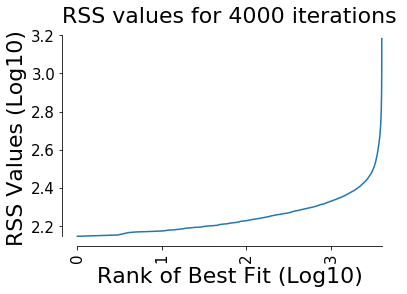

In [8]:
PyCoTools.PEAnalysis.EvaluateOptimizationPerformance(K.PE_data_global1,Log10='true')

This is a plot of the ordered likelihood (or RSS value) against iteration. The smooth curve indicates that the parameter estimation settings chosen for this problem are not a good choice. The absence of a monotonically increasing'step-like' shape suggests many optimizations are falling short of the minima that they are trying to find (Raue 2013). 

## Simulations Versus Experiment Plots

By chaining together the `InsertParameter` class with the `ParameterEstimation` class using the `CurrentSolutionStatistics` method, setting `Plot='true'` and `RandomizeStartValues='false'`, we can visualize a plot of simulated versus experimental data.  Note we could also use `Index=1` to get a visual on the second best parameter set (and so on) 

In [ ]:
PEData=PyCoTools.PEAnalysis.ParsePEData(K.PE_data_global1)

print 'best estimated parameters:\n',PEData.data.iloc[0].sort_index()
PyCoTools.pycopi.InsertParameters(K.kholodenko_model,ParameterPath=K.PEData_pickle,Index=0)
PE=PyCoTools.pycopi.ParameterEstimation(K.kholodenko_model,K.noisy_timecourse_report,
                                        Method='CurrentSolutionStatistics',
                                        Plot='true',
                                        SaveFig='false',
                                        RandomizeStartValues='false') #important to turn this off
PE.set_up() ## setup
PE.run()    ## and run the current solution statistics parameter estimation

These graphs give further indication that our estimations can do better. 

## Boxplots

In [ ]:
PyCoTools.PEAnalysis.PlotBoxplot(K.PE_data_global1,SaveFig='false',NumPerPlot=6)

Boxplots are very good at highlighting the fact that some parameters are more 'identifiable' than others. We'll get to this issue later. 

Since a large portion of the parameter estimations are 'bad' runs its often useful to get a visual of the data with these runs omited. 

In [ ]:
PyCoTools.PEAnalysis.PlotBoxplot(K.PE_data_global1,SaveFig='false',NumPerPlot=15,TruncateMode='below_x',X=2.3)

The box plots now look tidier and the `RSS` much tighter.

## Histograms

In [ ]:
PyCoTools.PEAnalysis.PlotHistogram(K.PE_data_global1,
                                   Log10='true', ##plot on log10 scale
                                   SaveFig='false',Bins=200)

Graphs can also be truncated by top `X` percent:

In [ ]:
PyCoTools.PEAnalysis.PlotHistogram(K.PE_data_global1,
                                   Log10='true', 
                                   SaveFig='false',Bins=30,
                                   TruncateMode='percent',X=10) ## Plot top 10% best runs

## Scatter Graphs

Scatter graphs are useful for identifying relationships between variables. Usually the most interesting are linear relationships which can (but not *always*) indicate structural non-identifiability and plots of the objective function versus estimated parameters. These tend to least to 'identifiability signatures' which can indicate the identifiability status of a parameter ahead of an identifiability analysis. 

The `PlotScatters` class automatically plots all ${{N}\choose{2}}$ pairs of estimated parameters and can therefore take some time with larger models. Since it consumes a lot of memory to plot and show all of these graphs, usually its preferable to write them to file instead. 

In [ ]:
PyCoTools.PEAnalysis.PlotScatters(K.PE_data_global1,SaveFig='false',
                                  Log10='true') 

## Hex Maps

Hex maps are an alternative to both scatter graphs and histograms depending on the `Mode` argument. When `Mode` is `count` (the default), colours represent counts like in a histogram style. Notice that because of the dispersion in the data, the `Log10='true'` usually is required to get a good look at the data with scatters and hex maps. Like scatter graphs, all  ${{N}\choose{2}}$ pairs are plotted automatically and therefore its preferable to write them to file instead of viewing in `ipython`. The `GridSize` and `Bins` keywords may need fine tuning by iteration to get decent looking plots. More information can be found [here](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hexbin)

In [10]:
PyCoTools.PEAnalysis.PlotHexMap(K.PE_data_global1,SaveFig='true',
                                  Log10='false',Show='false',Log10='true')

<PyCoTools.PEAnalysis.PlotHexMap instance at 0x000000002FC2C7C8>

When `Mode='RSS` hex maps are more like scatter graphs coloured by RSS value. 

In [12]:
PyCoTools.PEAnalysis.PlotHexMap(K.PE_data_global1,SaveFig='true',
                                  Log10='true',Show='false',Mode='RSS')

<PyCoTools.PEAnalysis.PlotHexMap instance at 0x0000000013025548>

## Secondary 'Chaser' Parameter Estimations

As mentioned previously, secondary 'chaser' parameter estimations are good for pushing a global algorithm's results a little further and can sometimes be extremely informative. This process could be done manually for a select few parameter sets but realistically this isn't an option without programming tools. The general idea is the same as what would be done manually: insert parameters into a model then setup and run a parameter estimation using a local method. Here is a function which does just that. 

In [ ]:
import os
import PyCoTools
import FilePaths

def runHJ(copasi_file,parameters,report_name,mode):
    '''
    copasi_file:
        file to run hook and jeeves on 
    parameters:
        dictionary of parameters. Keys must match model names, values are input parameters
    report_name:
        name of the report to output PE data.
    mode:
        either 'SGE' for SGE cluster or 'true' to run on current machine
    '''
    if 'RSS' in parameters.keys():
        del parameters['RSS']
    for i in parameters:
        print i,':\t',parameters[i]
    PyCoTools.pycopi.InsertParameters(copasi_file,ParameterDict=parameters)
    
    PE=PyCoTools.pycopi.ParameterEstimation(copasi_file,K.noisy_timecourse_report,
                                         Method='HookeJeeves',
                                         IterationLimit=20000,
                                         Tolerance=1e-30,
                                         RandomizeStartValues='false',
                                         Plot='true',
                                         SaveFig='true',
                                         UseTemplateStartValues='false',
                                         )

        
    PE.set_up()
    ## Run via scan task because this gives only best values in function
    ## evaluations, rather than the periodic function evaluations as well
    print '\n\n'
    print report_name
    print '\n'
    PyCoTools.pycopi.Scan(copasi_file,ScanType='repeat',Run=mode,
                          NumberOfSteps=1,
                          ReportName=report,
                          ReportType='parameter_estimation')
##Use the function
if __name__=='__main__':
    K=FilePaths.KholodenkoExample()
    data=PyCoTools.PEAnalysis.ParsePEData(K.PEData_pickle).data
    for i in range(int(data.shape[0]*0.025)):
        print 'running index {} with starting RSS of {}'.format(i,data.iloc[i]['RSS'])
        if os.path.isdir(K.local_PEData_dir)!=True:
            os.mkdir(K.local_PEData_dir)
        report=os.path.join(K.local_PEData_dir,'{}.txt'.format(i))
        print runHJ(K.kholodenko_model,data.iloc[i].to_dict(),report,'true')

# `Pydentify2`: Profile Likelihoods

Profile likelihoods are an extremely useful method of assessing a models identifiability status (Raue et al., 2009). This method (along with a number of other useful modelling tools) is impemented in a package called Data2Dynamics by the group that first used profile likelihoods in systems biology (Raue et al., 2015). COPASI users can also calculate profile likelihoods (Schaber, 2012) though the method is quite tedious. The `Pydentify2` module automates Schabers method while extending it to include calculation of profile likelihoods around multiple and an arbitrary number of parameter sets. Profile likelihoods are also visualized with the `Plot` class. The profile likelihood class can be used in three ways:

    1. Calculate profile likelihoods around the current point in parameter space. 

In [14]:
PyCoTools.pydentify2.ProfileLikelihood(K.kholodenko_model,
                                       LowerBoundMultiplier=1000, ## Sample 1000 times above and below the estimated parameter value
                                       UpperBoundMultiplier=1000,
                                       NumberOfSteps=25, 
                                       Run='false' #Just set up the profile likelihood right now
                                      )

<PyCoTools.pydentify2.ProfileLikelihood instance at 0x000000001B780348>

Internally, PyCoTools assigs an `Index=-1` when no `ParameterPath` argument is specified. The analysis is set up in `<pathToModel>\ProfileLikelihood\-1`. When this method is used, you must take note of the `RSS` value for the estimation which produced the current parameters as it is used in the calculation of confidence levels and is not easily accessible programmatically. 

    2. Provide argument  to `ParameterPath` to take parameters from a file or folder of files, indexed by rank of best fit

In [ ]:
PyCoTools.pydentify2.ProfileLikelihood(K.kholodenko_model,
                                       ParameterPath=K.PE_data_global1,
                                       Index=0, ## 0 is best fitting (lowest RSS) parameter set
                                       LowerBoundMultiplier=1000, ## Sample 1000 times above and below the estimated parameter value
                                       UpperBoundMultiplier=1000,
                                       NumberOfSteps=25, 
                                       Run='false' #Just set up the profile likelihood
                                      )

Now the `RSS` is automatically taken from the parameter estimation data which is why this is the preferred method of use. Now the analysis can be found under the `<PathToModel>\ProfileLikelihood\0`. 
    3. Provide a list of indices to the `Index` keyword to calculate profile likelihoods around multiple parameter sets

In [ ]:
range_of_indices=range(0,10,2)
print 'indices used: {}'.format(range_of_indices)
PyCoTools.pydentify2.ProfileLikelihood(K.kholodenko_model,
                                       ParameterPath=K.PE_data_global1,
                                       Index=range_of_indices,
                                       LowerBoundMultiplier=1000, ## Sample 1000 times above and below the estimated parameter value
                                       UpperBoundMultiplier=1000,
                                       NumberOfSteps=25, 
                                       Run='false' #Just set up the profile likelihood
                                      )

Each method (referred to as `methods 1-3`) can be run in exactly the same way: by specifying an argument to the `Run` keyword. There are 4 options:
    1. `Run='false'` -  set up but do not run the profile likelihood analysis
    2. `Run='slow'`  -  set up and run the profile likleihoods in serial, using a single process. 
    3. `Run='multiprocess'` - set up and run profilelikelihoods on separate process in parallel. 
    4. `Run='SGE'` - set up and run on a SunGrid engine based job scheduler. 
    
Using the `multiprocess` mode is not currently very sophisticated method of running in parallel. In fact, this isn't true parallel programming since the models are simply opened and run by multiple processes. This mode takes all models and runs them simultaneously on separate processes. Because of this, it will take all of a computers memory with >4-6 parameters (which are separate models) being run in parallel. For this reason it is only reccommended to use this mode when the computer isn't needed until the analysis is finished. 

## Running on a Cluster

Sun grid engine users may use the `SGE` mode. This writes a `.sh` script containing commands to submit and run the model via CopasiSE on the cluster. For this reason, people with a SGE cluster but not at Newcastle University will probably have the modify the following snippet of code in the `PyCoTools.pydentify2.ProfileLikelihood().run_SGE` source code to include the directory to COPASI on their own cluster. 

    with open('run_script.sh','w') as f:
        f.write('#!/bin/bash\n#$ -V -cwd\nmodule addapps/COPASI/4.16.104-Linux-64bit\nCopasiSE "{}"'.format(self.cps_dct[i][j]))
                    
People using a job scheduler other than SGE will have to write their own function to submit the analysis. To do this simply copy the `run_SGE` method of the ProfileLikelihood class, change the contents of the `.sh` file and the `os.system` command to whatever is necessary for your own cluster. When using the `ProfileLikelihood` class arguments are checked for validity. Therefore you need to add a `Mode` to the class by modifying the `__init__` section of `ProfileLikelihood` class, specifically the bit which raises an error if the argument passed to `Run` isn't one of `['false','slow','multiprocess','SGE']`:

i.e. change 

    if self.kwargs.get('Run') not in ['false','slow','multiprocess','SGE']:
        raise Errors.InputError('\'Run\' keyword must be one of \'slow\', \'false\',\'multiprocess\', or \'SGE\'')
        
to

    if self.kwargs.get('Run') not in ['false','slow','multiprocess','SGE','other_job_scheduler']:
        raise Errors.InputError('\'Run\' keyword must be one of \'slow\', \'false\',\'multiprocess\', or \'SGE\' or \'other_job_scheduler\' ')

# Refernces

* Raue, A., Schilling, M., Bachmann, J., Matteson, A., Schelke, M., Kaschek, D., Hug, S., Kreutz, C., Harms, B.D., Theis, F.J., Klingmüller, U. and Timmer, J. (2013) 'Lessons Learned from Quantitative Dynamical Modeling in Systems Biology', PLoS ONE, 8(9), p. e74335.
* Raue, A., Kreutz, C., Maiwald, T., Bachmann, J., Schilling, M., Klingmüller, U. and Timmer, J. (2009) 'Structural and practical identifiability analysis of partially observed dynamical models by exploiting the profile likelihood', Bioinformatics, 25(15), pp. 1923-1929.
* Schaber, J. (2012) 'Easy parameter identifiability analysis with COPASI', Biosystems, 110(3), pp. 183-185.
* Raue, A., Steiert, B., Schelker, M., Kreutz, C., Maiwald, T., Hass, H., Vanlier, J., Tönsing, C., Adlung, L., Engesser, R., Mader, W., Heinemann, T., Hasenauer, J., Schilling, M., Höfer, T., Klipp, E., Theis, F., Klingmüller, U., Schöberl, B. and Timmer, J. (2015) 'Data2Dynamics: a modeling environment tailored to parameter estimation in dynamical systems', Bioinformatics.
